In [1]:
import jax
import jax.numpy as jnp
import optax
from jax import grad, jit
import numpy as np

import matplotlib.pyplot as plt

def heatmap_from_array(P, ax=None):  
    n = len(P)
    PX = P[:, 0]
    PY = P[:, 1]

    X = [0.001 * i for i in range(1001)]
    Y = [0.001 * i for i in range(1001)]
    Z = [[0 for _ in range(1001)] for _ in range(1001)]

    maxi = 0
    mxii = 0
    mxjj = 0
    for i in range(1001):
        for j in range(1001):
            Z[j][i] = locdisc(X[i], Y[j], P)
            if Z[j][i] > maxi:
                maxi = Z[j][i]
                mxii = i
                mxjj = j

    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 6))

    cs = ax.contourf(X, Y, Z, levels=40, cmap="viridis")
    plt.colorbar(cs, ax=ax, label="Local Discrepancy")
    ax.scatter(PX, PY, c='r', s=50, linewidth=1, alpha=0.7)
    ax.scatter(mxii/1000, mxjj/1000, c='black')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect('equal')

    return ax, maxi

def Linf_discrepancy(P, grid_size=300):
    # Evaluate discrepancy on a dense grid and take the max value
    xs = np.linspace(0, 1, grid_size)
    ys = np.linspace(0, 1, grid_size)
    X, Y = np.meshgrid(xs, ys)
    points_grid = np.stack([X.ravel(), Y.ravel()], axis=1)

    # For each grid point x, count proportion of P in [0,x1]x[0,x2]
    count = np.sum((P[:, None, 0] <= points_grid[:, 0]) &
                   (P[:, None, 1] <= points_grid[:, 1]), axis=0)
    N = len(P)
    discrepancy = np.abs(count / N - points_grid[:, 0] * points_grid[:, 1])
    return np.max(discrepancy)

def locdisc(x, y, P):
    no = 0
    nc = 0
    n = len(P)
    for i in range(n):
        if P[i][0] < x and P[i][1] < y:
            no += 1
        if P[i][0] <= x and P[i][1] <= y:
            nc += 1
    return max(x*y - no/n, nc/n - x*y)

def plot_points(P, title="Point Set"):
    P_np = jnp.array(P) if isinstance(P, jax.Array) else P
    plt.figure(figsize=(4, 4))
    plt.scatter(P_np[:, 0], P_np[:, 1], c='blue', s=30)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.title(title)
    plt.gca().set_aspect('equal')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

def softmax(a, b, tau=1e-16):
    return 0.5 * (a + b + jnp.sqrt((a - b)**2 + tau))

# Smoothed L2 star discrepancy function
def L2_smoothed(P, tau=1e-16):
    n = P.shape[0]
    a = jnp.sum((1 - P[:, 0]**2) * (1 - P[:, 1]**2)) / (2 * n)

    # Compute pairwise (i, j) terms using broadcasting
    x = P[:, 0]
    y = P[:, 1]
    xi, xj = jnp.meshgrid(x, x, indexing='ij')
    yi, yj = jnp.meshgrid(y, y, indexing='ij')

    smax0 = softmax(xi, xj, tau)
    smax1 = softmax(yi, yj, tau)
    b = jnp.sum((1 - smax0) * (1 - smax1)) / (n**2)

    return 1/9 - a + b

def fibonacci_lattice(n):
    phi = (jnp.sqrt(5) - 1) / 2  # 1/Golden ratio
    i = jnp.arange(n)
    x = i / n
    y = (i * phi) % 1  # fractional part
    return jnp.stack([x, y], axis=1)


def L2_discrepancy(P):
    N, d = P.shape

    prod1 = 1. - P ** 2
    prod1 = np.prod(prod1, axis=1)
    sum1 = np.sum(prod1)

    # Broadcasting to compute pairwise max across dimensions
    P1 = P[:, np.newaxis, :]  # shape (N, 1, d)
    P2 = P[np.newaxis, :, :]  # shape (1, N, d)
    pairwise_max = np.maximum(P1, P2)  # shape (N, N, d)

    product = np.prod(1. - pairwise_max, axis=2)
    sum2 = np.sum(product)

    one_div_N = 1. / N
    out = np.sqrt(
        np.power(3., -d)
        - one_div_N * np.power(2., 1. - d) * sum1
        + (1. / np.power(N, 2.)) * sum2
    )

    return out




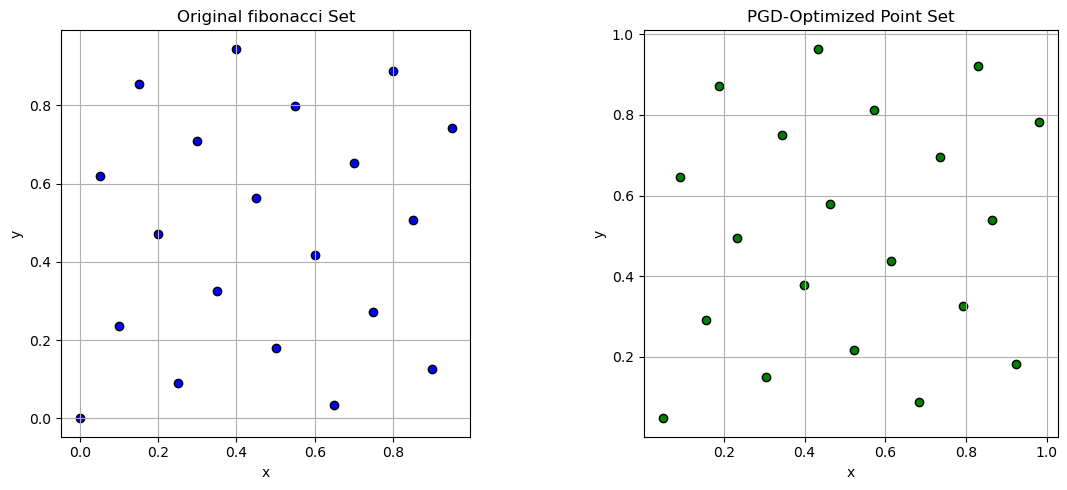

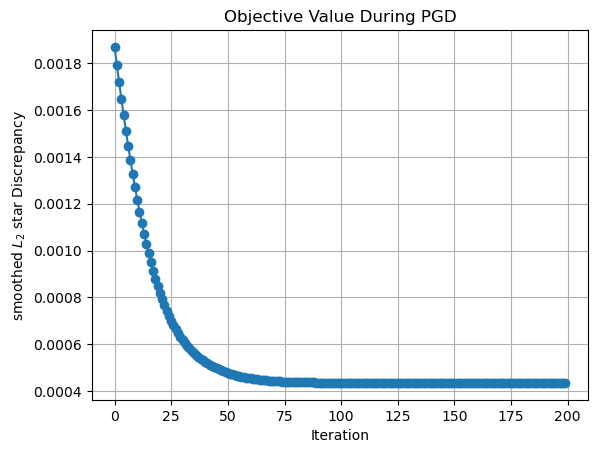

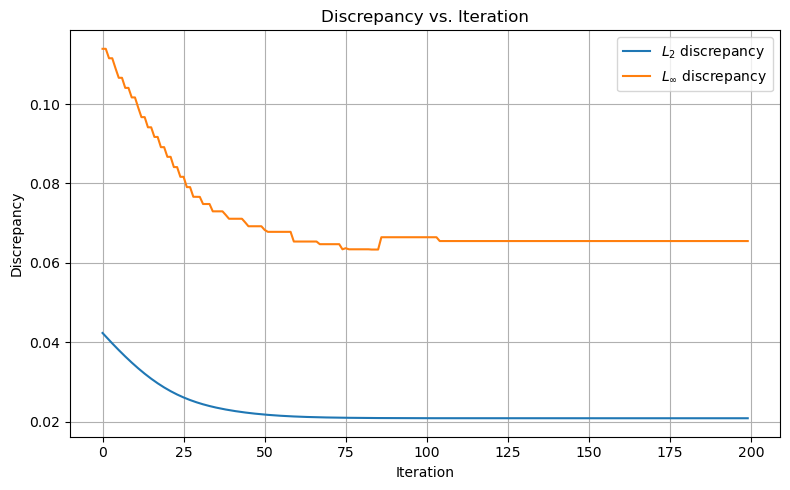

Initial L2 discrepancy: 0.043237260509622316
Final L2 discrepancy value: 0.020862438360146854
Optimized Points:
 [[0.04772511 0.04772511]
 [0.09112266 0.64615697]
 [0.15489726 0.29029128]
 [0.18699497 0.87171239]
 [0.23109987 0.49463576]
 [0.30407664 0.14997092]
 [0.34367079 0.74935842]
 [0.39843959 0.37840304]
 [0.43278375 0.96405524]
 [0.46396258 0.57922345]
 [0.52297354 0.21821128]
 [0.57244676 0.81292957]
 [0.61536139 0.43719003]
 [0.68285775 0.08913013]
 [0.73587132 0.69612718]
 [0.79186362 0.32721633]
 [0.83061302 0.92075193]
 [0.8653174  0.53939009]
 [0.92437983 0.18188442]
 [0.98064166 0.78257704]]


In [2]:
# Use it for initial points
n = 20
P_init = fibonacci_lattice(n)

# ADAM optimizer setup
learning_rate = 0.001
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(P_init)

# Define loss function and gradient
loss_fn = lambda P: L2_smoothed(P)
loss_and_grad = jax.value_and_grad(loss_fn)

# Optimization loop
P = P_init
objective_history = []

L2_values = []
Linf_values = []

for i in range(200):
    loss_val, grads = loss_and_grad(P)
    updates, opt_state = optimizer.update(grads, opt_state)
    P = optax.apply_updates(P, updates)

    # Clamp to [0, 1]^2
    P = jnp.clip(P, 0.0, 1.0)
    objective_history.append(loss_val)
    
    L2_values.append(float(L2_discrepancy(np.array(P))))
    Linf_values.append(float(Linf_discrepancy(np.array(P))))


init_points = np.asarray(P_init).astype(np.float64)
optimized_points = np.asarray(P).astype(np.float64)
initial_discrepancy_value = L2_discrepancy(init_points)

# === Side-by-side: point sets ===
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(init_points[:, 0], init_points[:, 1], c='blue', edgecolor='black')
axs[0].set_title("Original fibonacci Set")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].grid(True)
axs[0].set_aspect('equal')

axs[1].scatter(optimized_points[:, 0], optimized_points[:, 1], c='green', edgecolor='black')
axs[1].set_title("PGD-Optimized Point Set")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].grid(True)
axs[1].set_aspect('equal')

plt.tight_layout()
plt.show()


# === Objective plot ===
plt.figure()
plt.plot(objective_history, marker='o')
plt.title("Objective Value During PGD")
plt.xlabel("Iteration")
plt.ylabel("smoothed $L_2$ star Discrepancy")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(L2_values, label=r'$L_2$ discrepancy')
plt.plot(Linf_values, label=r'$L_\infty$ discrepancy')
plt.xlabel("Iteration")
plt.ylabel("Discrepancy")
plt.title("Discrepancy vs. Iteration")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Output ===
print("Initial L2 discrepancy:", initial_discrepancy_value)
print("Final L2 discrepancy value:", L2_discrepancy(optimized_points))
print("Optimized Points:\n", optimized_points)



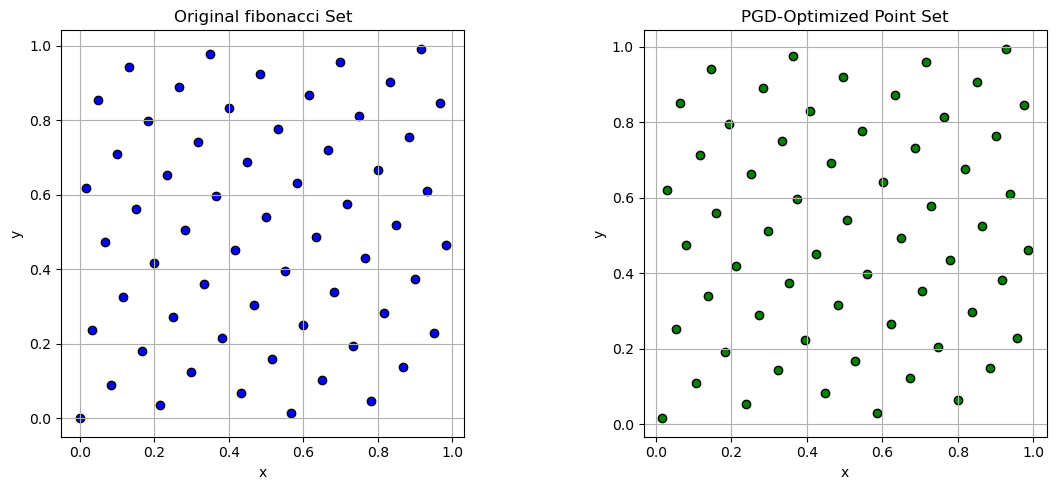

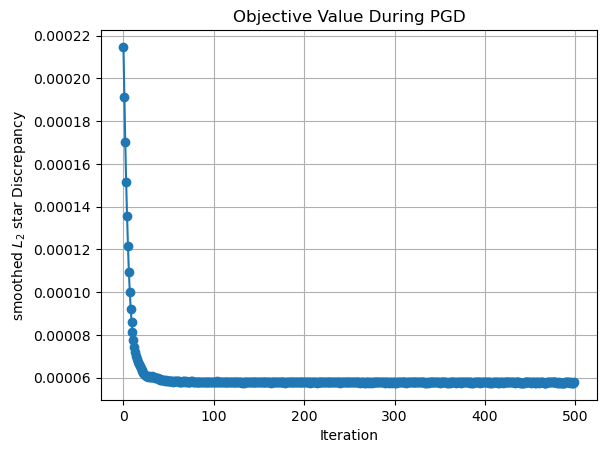

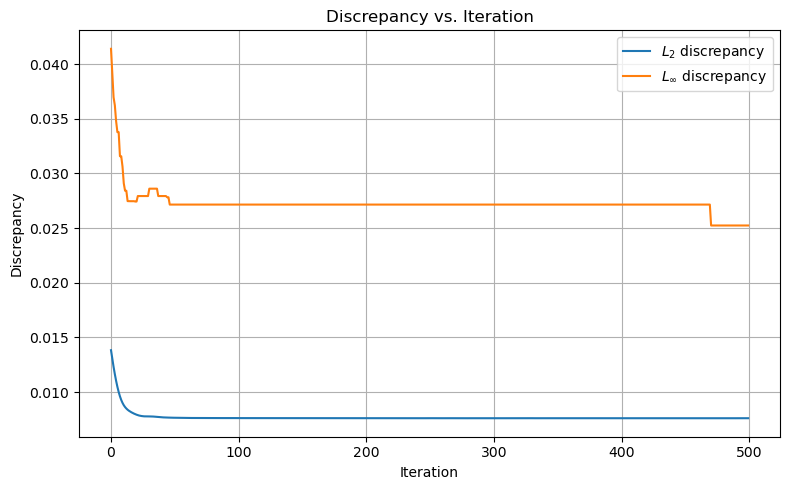

Initial L2 discrepancy: 0.014649880197247047
Final L2 discrepancy value: 0.0076053167480048985
Optimized Points:
 [[0.01639778 0.01639778]
 [0.0308257  0.62202179]
 [0.05337574 0.25256455]
 [0.06299777 0.85191566]
 [0.07914808 0.47439447]
 [0.10574351 0.11021782]
 [0.11700899 0.71468759]
 [0.13742511 0.34116852]
 [0.14601573 0.94042903]
 [0.15981324 0.56052995]
 [0.18212476 0.19187751]
 [0.19522329 0.79518288]
 [0.21171401 0.41885266]
 [0.23884284 0.05503449]
 [0.25198305 0.66238058]
 [0.27382189 0.28947011]
 [0.28281456 0.89170641]
 [0.29802382 0.51251251]
 [0.32256919 0.14380683]
 [0.33489999 0.75045872]
 [0.35365686 0.37442842]
 [0.36257219 0.97661644]
 [0.37473181 0.5956223 ]
 [0.39456823 0.22362939]
 [0.40977669 0.82889652]
 [0.42414215 0.45092088]
 [0.44701725 0.08316882]
 [0.46412897 0.69143414]
 [0.48302263 0.31633791]
 [0.49543104 0.92003912]
 [0.50762582 0.54005224]
 [0.52782059 0.16883413]
 [0.54523718 0.77561688]
 [0.56054765 0.39862993]
 [0.58488828 0.03154799]
 [0.6018635

In [3]:
# Use it for initial points
n = 60
P_init = fibonacci_lattice(n)

# ADAM optimizer setup
learning_rate = 0.001
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(P_init)

# Define loss function and gradient
loss_fn = lambda P: L2_smoothed(P)
loss_and_grad = jax.value_and_grad(loss_fn)

# Optimization loop
P = P_init
objective_history = []

L2_values = []
Linf_values = []

for i in range(500):
    loss_val, grads = loss_and_grad(P)
    updates, opt_state = optimizer.update(grads, opt_state)
    P = optax.apply_updates(P, updates)

    # Clamp to [0, 1]^2
    P = jnp.clip(P, 0.0, 1.0)
    objective_history.append(loss_val)
    
    L2_values.append(float(L2_discrepancy(np.array(P))))
    Linf_values.append(float(Linf_discrepancy(np.array(P))))


init_points = np.asarray(P_init).astype(np.float64)
optimized_points = np.asarray(P).astype(np.float64)
initial_discrepancy_value = L2_discrepancy(init_points)

# === Side-by-side: point sets ===
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(init_points[:, 0], init_points[:, 1], c='blue', edgecolor='black')
axs[0].set_title("Original fibonacci Set")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].grid(True)
axs[0].set_aspect('equal')

axs[1].scatter(optimized_points[:, 0], optimized_points[:, 1], c='green', edgecolor='black')
axs[1].set_title("PGD-Optimized Point Set")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].grid(True)
axs[1].set_aspect('equal')

plt.tight_layout()
plt.show()


# === Objective plot ===
plt.figure()
plt.plot(objective_history, marker='o')
plt.title("Objective Value During PGD")
plt.xlabel("Iteration")
plt.ylabel("smoothed $L_2$ star Discrepancy")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(L2_values, label=r'$L_2$ discrepancy')
plt.plot(Linf_values, label=r'$L_\infty$ discrepancy')
plt.xlabel("Iteration")
plt.ylabel("Discrepancy")
plt.title("Discrepancy vs. Iteration")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Output ===
print("Initial L2 discrepancy:", initial_discrepancy_value)
print("Final L2 discrepancy value:", L2_discrepancy(optimized_points))
print("Optimized Points:\n", optimized_points)

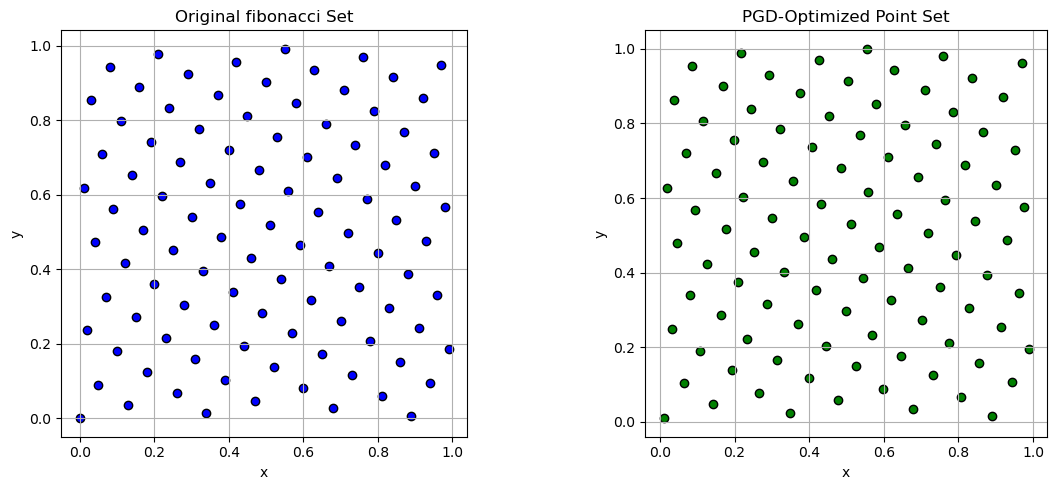

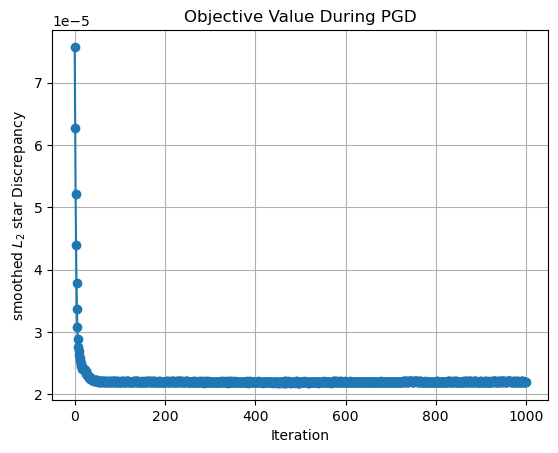

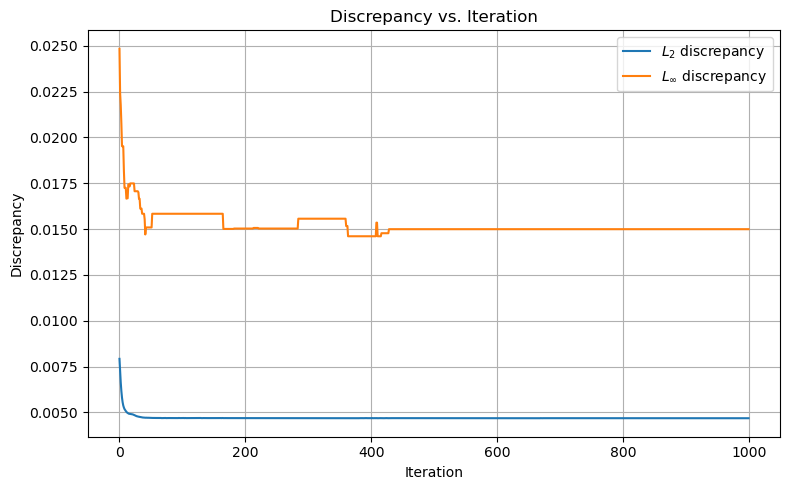

Initial L2 discrepancy: 0.008702476381432738
Final L2 discrepancy value: 0.0046839771605163725
Optimized Points:
 [[0.00990195 0.00990195]
 [0.01842422 0.62829119]
 [0.03193874 0.2494027 ]
 [0.03756244 0.86356384]
 [0.04698993 0.47988707]
 [0.06313313 0.10440537]
 [0.06958796 0.72156549]
 [0.08178433 0.34026408]
 [0.08700779 0.95384896]
 [0.09473754 0.56872535]
 [0.10829346 0.19056401]
 [0.11562157 0.80659103]
 [0.12546869 0.42348504]
 [0.14226951 0.04839302]
 [0.14955175 0.66707301]
 [0.16278315 0.28635383]
 [0.167961   0.90140194]
 [0.17680976 0.5167675 ]
 [0.19202545 0.13893668]
 [0.19867633 0.75665671]
 [0.2100438  0.37393335]
 [0.21624704 0.9884693 ]
 [0.22225539 0.60271192]
 [0.2345558  0.22273412]
 [0.24271825 0.83920842]
 [0.25152674 0.45528847]
 [0.26611426 0.07825783]
 [0.27527171 0.6972754 ]
 [0.28691503 0.31543335]
 [0.29348204 0.9311108 ]
 [0.30103281 0.54603744]
 [0.31385085 0.16685872]
 [0.32302004 0.78470546]
 [0.33254996 0.40135098]
 [0.34847951 0.02477977]
 [0.3572439

In [4]:
# Use it for initial points
n = 100
P_init = fibonacci_lattice(n)

# ADAM optimizer setup
learning_rate = 0.001
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(P_init)

# Define loss function and gradient
loss_fn = lambda P: L2_smoothed(P)
loss_and_grad = jax.value_and_grad(loss_fn)

# Optimization loop
P = P_init
objective_history = []

L2_values = []
Linf_values = []

for i in range(1000):
    loss_val, grads = loss_and_grad(P)
    updates, opt_state = optimizer.update(grads, opt_state)
    P = optax.apply_updates(P, updates)

    # Clamp to [0, 1]^2
    P = jnp.clip(P, 0.0, 1.0)
    objective_history.append(loss_val)
    
    L2_values.append(float(L2_discrepancy(np.array(P))))
    Linf_values.append(float(Linf_discrepancy(np.array(P))))


init_points = np.asarray(P_init).astype(np.float64)
optimized_points = np.asarray(P).astype(np.float64)
initial_discrepancy_value = L2_discrepancy(init_points)

# === Side-by-side: point sets ===
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(init_points[:, 0], init_points[:, 1], c='blue', edgecolor='black')
axs[0].set_title("Original fibonacci Set")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].grid(True)
axs[0].set_aspect('equal')

axs[1].scatter(optimized_points[:, 0], optimized_points[:, 1], c='green', edgecolor='black')
axs[1].set_title("PGD-Optimized Point Set")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].grid(True)
axs[1].set_aspect('equal')

plt.tight_layout()
plt.show()


# === Objective plot ===
plt.figure()
plt.plot(objective_history, marker='o')
plt.title("Objective Value During PGD")
plt.xlabel("Iteration")
plt.ylabel("smoothed $L_2$ star Discrepancy")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(L2_values, label=r'$L_2$ discrepancy')
plt.plot(Linf_values, label=r'$L_\infty$ discrepancy')
plt.xlabel("Iteration")
plt.ylabel("Discrepancy")
plt.title("Discrepancy vs. Iteration")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Output ===
print("Initial L2 discrepancy:", initial_discrepancy_value)
print("Final L2 discrepancy value:", L2_discrepancy(optimized_points))
print("Optimized Points:\n", optimized_points)

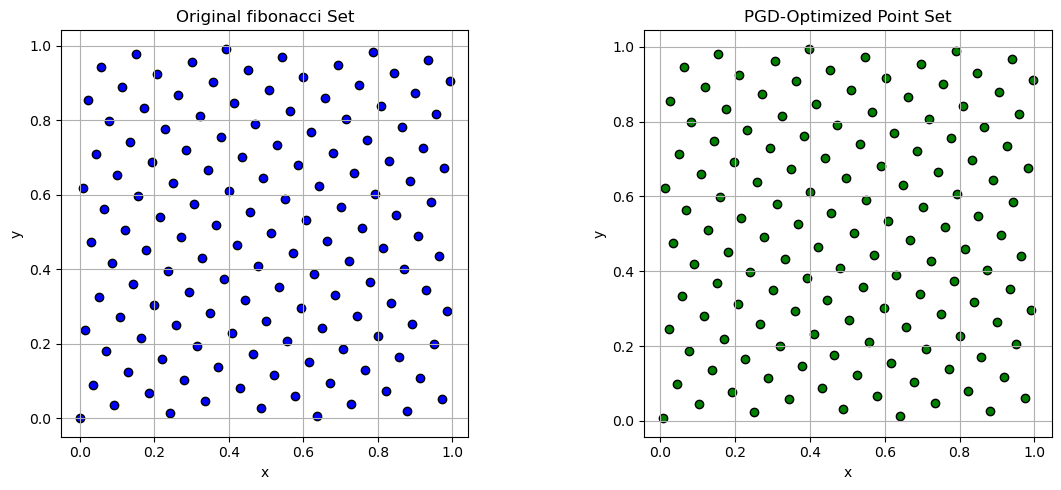

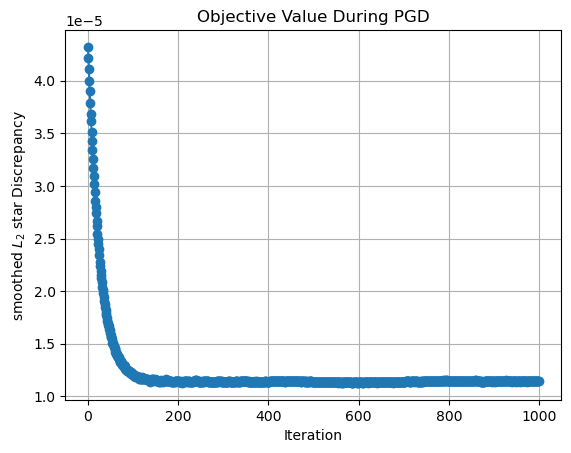

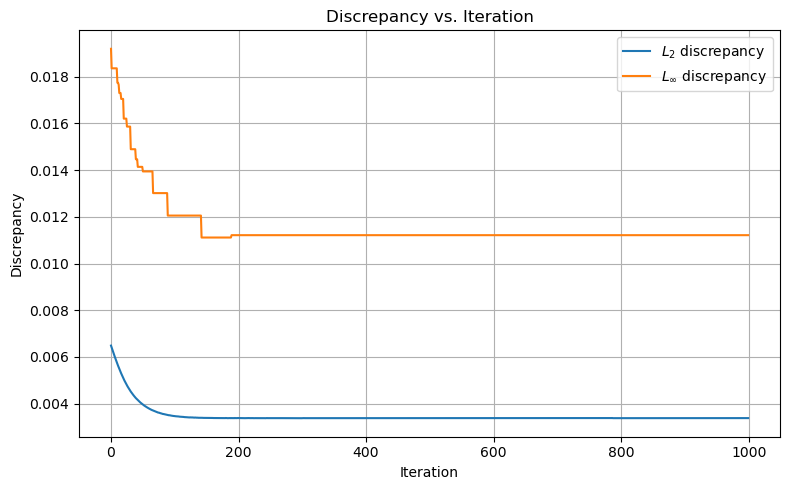

Initial L2 discrepancy: 0.006572032254621162
Final L2 discrepancy value: 0.0033810841889739367
Optimized Points:
 [[0.00709255 0.00709255]
 [0.01321087 0.62204099]
 [0.02296215 0.24442571]
 [0.0269346  0.85634857]
 [0.03383488 0.47519764]
 [0.0454835  0.09997987]
 [0.05002907 0.7138809 ]
 [0.05890132 0.33453339]
 [0.06240312 0.94587368]
 [0.06829388 0.56368268]
 [0.07811252 0.18666922]
 [0.08324706 0.79973316]
 [0.0904289  0.41913515]
 [0.10265681 0.04450744]
 [0.10768523 0.65952629]
 [0.11733197 0.28081861]
 [0.12078513 0.8931669 ]
 [0.12743416 0.5114243 ]
 [0.13854232 0.13481298]
 [0.14303327 0.74895632]
 [0.15139586 0.36874419]
 [0.15507872 0.98056144]
 [0.16026863 0.59797096]
 [0.16924912 0.21987128]
 [0.1748915  0.8331461 ]
 [0.18134159 0.45194045]
 [0.19207482 0.07597558]
 [0.19832039 0.69100755]
 [0.20684029 0.31145081]
 [0.2113743  0.92403668]
 [0.21698681 0.54193306]
 [0.2264007  0.16443717]
 [0.23264606 0.7786358 ]
 [0.23966044 0.39796922]
 [0.25146732 0.02260363]
 [0.2573511

In [5]:
# Use it for initial points
n = 140
P_init = fibonacci_lattice(n)

# ADAM optimizer setup
learning_rate = 0.0001
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(P_init)

# Define loss function and gradient
loss_fn = lambda P: L2_smoothed(P)
loss_and_grad = jax.value_and_grad(loss_fn)

# Optimization loop
P = P_init
objective_history = []

L2_values = []
Linf_values = []

for i in range(1000):
    loss_val, grads = loss_and_grad(P)
    updates, opt_state = optimizer.update(grads, opt_state)
    P = optax.apply_updates(P, updates)

    # Clamp to [0, 1]^2
    P = jnp.clip(P, 0.0, 1.0)
    objective_history.append(loss_val)
    
    L2_values.append(float(L2_discrepancy(np.array(P))))
    Linf_values.append(float(Linf_discrepancy(np.array(P))))


init_points = np.asarray(P_init).astype(np.float64)
optimized_points = np.asarray(P).astype(np.float64)
initial_discrepancy_value = L2_discrepancy(init_points)

# === Side-by-side: point sets ===
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(init_points[:, 0], init_points[:, 1], c='blue', edgecolor='black')
axs[0].set_title("Original fibonacci Set")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].grid(True)
axs[0].set_aspect('equal')

axs[1].scatter(optimized_points[:, 0], optimized_points[:, 1], c='green', edgecolor='black')
axs[1].set_title("PGD-Optimized Point Set")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].grid(True)
axs[1].set_aspect('equal')

plt.tight_layout()
plt.show()


# === Objective plot ===
plt.figure()
plt.plot(objective_history, marker='o')
plt.title("Objective Value During PGD")
plt.xlabel("Iteration")
plt.ylabel("smoothed $L_2$ star Discrepancy")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(L2_values, label=r'$L_2$ discrepancy')
plt.plot(Linf_values, label=r'$L_\infty$ discrepancy')
plt.xlabel("Iteration")
plt.ylabel("Discrepancy")
plt.title("Discrepancy vs. Iteration")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Output ===
print("Initial L2 discrepancy:", initial_discrepancy_value)
print("Final L2 discrepancy value:", L2_discrepancy(optimized_points))
print("Optimized Points:\n", optimized_points)

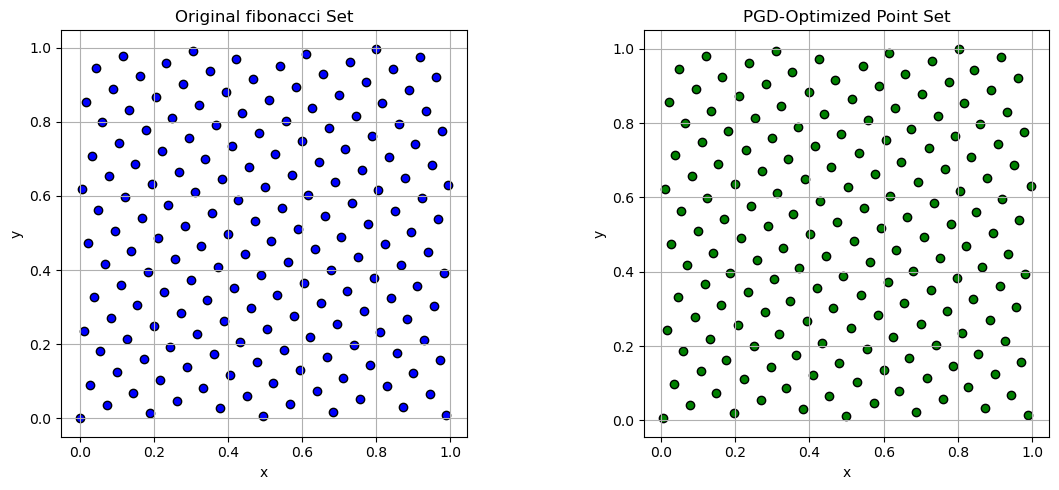

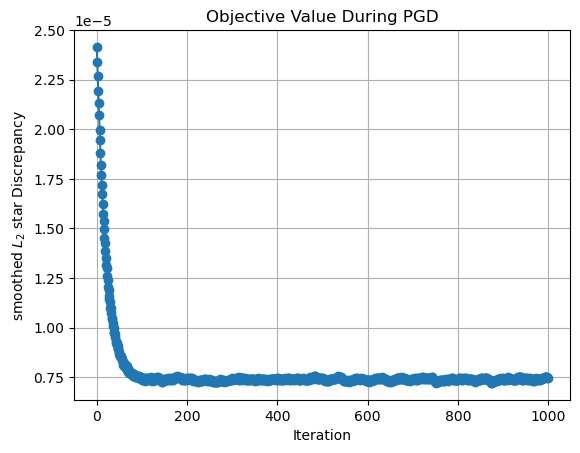

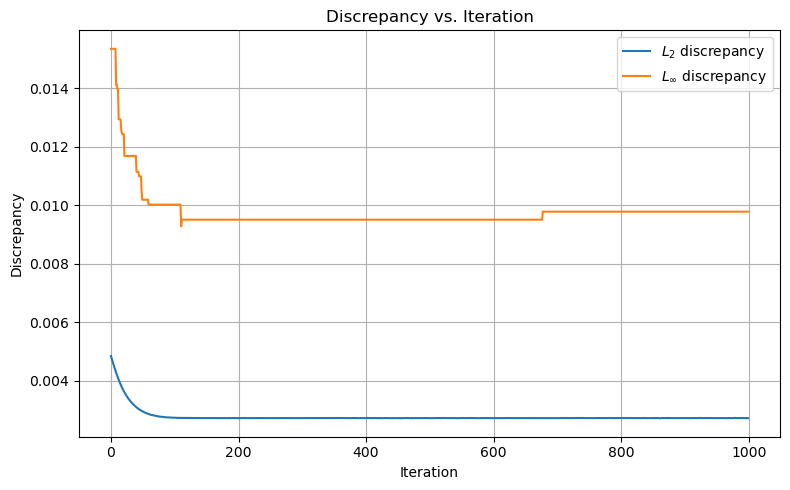

Initial L2 discrepancy: 0.004916913916361618
Final L2 discrepancy value: 0.0027158753973517053
Optimized Points:
 [[0.00552503 0.00552503]
 [0.01027641 0.62183851]
 [0.01787563 0.2428003 ]
 [0.02094476 0.85673809]
 [0.02631439 0.47491175]
 [0.03541666 0.09781356]
 [0.03890983 0.7132585 ]
 [0.0458367  0.3328869 ]
 [0.04852333 0.94637412]
 [0.05311636 0.56374705]
 [0.06080152 0.18522409]
 [0.06471913 0.7999531 ]
 [0.07033432 0.41857016]
 [0.07995127 0.04200135]
 [0.08376019 0.65823716]
 [0.0913265  0.27839309]
 [0.09392992 0.89257127]
 [0.09914507 0.51032531]
 [0.10790202 0.13226831]
 [0.1112499  0.74783826]
 [0.11782887 0.36685845]
 [0.12061273 0.98062986]
 [0.12469969 0.59771174]
 [0.13178803 0.21843226]
 [0.13601324 0.83326882]
 [0.14110111 0.45145065]
 [0.14963017 0.07394652]
 [0.15427728 0.69016987]
 [0.1610042  0.30971596]
 [0.16435915 0.92404014]
 [0.16882385 0.54149985]
 [0.17630863 0.1627191 ]
 [0.18092884 0.77823806]
 [0.1864953  0.3968451 ]
 [0.19595532 0.01985556]
 [0.2002466

In [6]:
# Use it for initial points
n = 180
P_init = fibonacci_lattice(n)

# ADAM optimizer setup
learning_rate = 0.0001
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(P_init)

# Define loss function and gradient
loss_fn = lambda P: L2_smoothed(P)
loss_and_grad = jax.value_and_grad(loss_fn)

# Optimization loop
P = P_init
objective_history = []

L2_values = []
Linf_values = []

for i in range(1000):
    loss_val, grads = loss_and_grad(P)
    updates, opt_state = optimizer.update(grads, opt_state)
    P = optax.apply_updates(P, updates)

    # Clamp to [0, 1]^2
    P = jnp.clip(P, 0.0, 1.0)
    objective_history.append(loss_val)
    
    L2_values.append(float(L2_discrepancy(np.array(P))))
    Linf_values.append(float(Linf_discrepancy(np.array(P))))


init_points = np.asarray(P_init).astype(np.float64)
optimized_points = np.asarray(P).astype(np.float64)
initial_discrepancy_value = L2_discrepancy(init_points)

# === Side-by-side: point sets ===
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(init_points[:, 0], init_points[:, 1], c='blue', edgecolor='black')
axs[0].set_title("Original fibonacci Set")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].grid(True)
axs[0].set_aspect('equal')

axs[1].scatter(optimized_points[:, 0], optimized_points[:, 1], c='green', edgecolor='black')
axs[1].set_title("PGD-Optimized Point Set")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].grid(True)
axs[1].set_aspect('equal')

plt.tight_layout()
plt.show()


# === Objective plot ===
plt.figure()
plt.plot(objective_history, marker='o')
plt.title("Objective Value During PGD")
plt.xlabel("Iteration")
plt.ylabel("smoothed $L_2$ star Discrepancy")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(L2_values, label=r'$L_2$ discrepancy')
plt.plot(Linf_values, label=r'$L_\infty$ discrepancy')
plt.xlabel("Iteration")
plt.ylabel("Discrepancy")
plt.title("Discrepancy vs. Iteration")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Output ===
print("Initial L2 discrepancy:", initial_discrepancy_value)
print("Final L2 discrepancy value:", L2_discrepancy(optimized_points))
print("Optimized Points:\n", optimized_points)

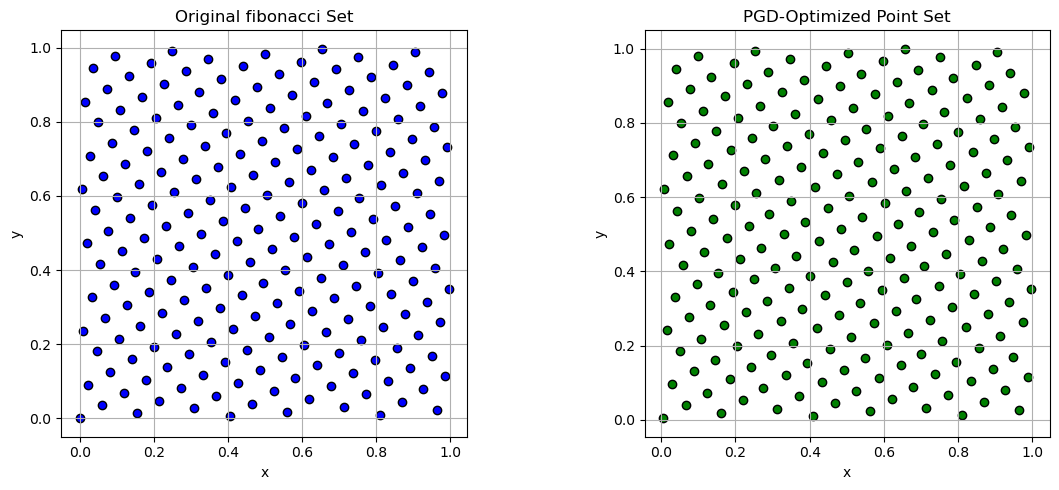

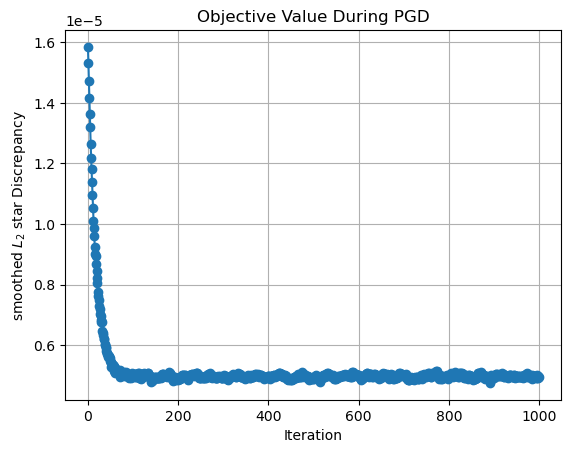

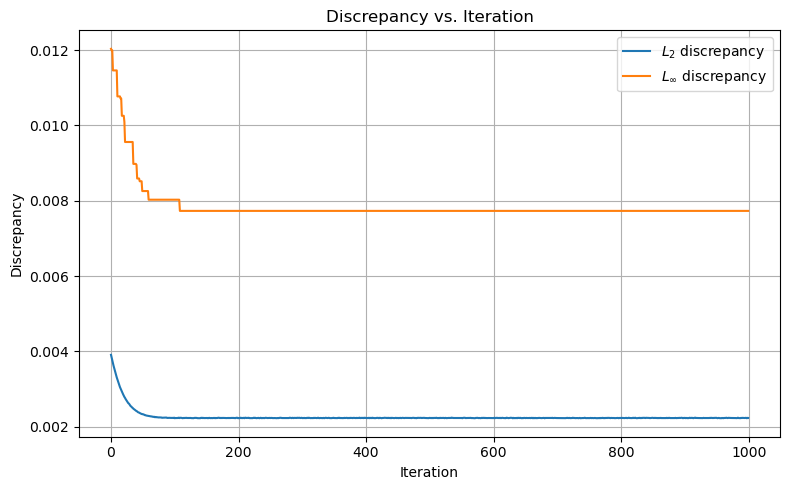

Initial L2 discrepancy: 0.003985410453478598
Final L2 discrepancy value: 0.0022318093864750854
Optimized Points:
 [[0.00452498 0.00452498]
 [0.0084102  0.62141156]
 [0.01463741 0.24168986]
 [0.01713753 0.85664165]
 [0.02153695 0.47464031]
 [0.02900517 0.09653882]
 [0.03184218 0.71272469]
 [0.03752378 0.33194277]
 [0.03969881 0.94647938]
 [0.04347152 0.56380612]
 [0.04978029 0.18452735]
 [0.05295129 0.80008483]
 [0.05755803 0.41845196]
 [0.06547189 0.0408193 ]
 [0.06854337 0.65761632]
 [0.07475905 0.27728406]
 [0.07685146 0.89234102]
 [0.08114039 0.50998724]
 [0.08835129 0.13112321]
 [0.09103046 0.74732172]
 [0.09644216 0.36603847]
 [0.0986788  0.98072046]
 [0.10205673 0.59782058]
 [0.10789166 0.21797575]
 [0.11128677 0.83358121]
 [0.11547187 0.45161557]
 [0.12251729 0.07328129]
 [0.12624075 0.69004709]
 [0.13177456 0.30924752]
 [0.13446018 0.92439187]
 [0.13814649 0.54180282]
 [0.14432175 0.16238542]
 [0.14801659 0.77853227]
 [0.15260185 0.39692292]
 [0.16043854 0.01904385]
 [0.1638550

In [14]:
# Use it for initial points
n = 220
P_init = fibonacci_lattice(n)

# ADAM optimizer setup
learning_rate = 0.0001
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(P_init)

# Define loss function and gradient
loss_fn = lambda P: L2_smoothed(P)
loss_and_grad = jax.value_and_grad(loss_fn)

# Optimization loop
P = P_init
objective_history = []

L2_values = []
Linf_values = []

for i in range(1000):
    loss_val, grads = loss_and_grad(P)
    updates, opt_state = optimizer.update(grads, opt_state)
    P = optax.apply_updates(P, updates)

    # Clamp to [0, 1]^2
    P = jnp.clip(P, 0.0, 1.0)
    objective_history.append(loss_val)
    
    L2_values.append(float(L2_discrepancy(np.array(P))))
    Linf_values.append(float(Linf_discrepancy(np.array(P))))


init_points = np.asarray(P_init).astype(np.float64)
optimized_points = np.asarray(P).astype(np.float64)
initial_discrepancy_value = L2_discrepancy(init_points)

# === Side-by-side: point sets ===
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(init_points[:, 0], init_points[:, 1], c='blue', edgecolor='black')
axs[0].set_title("Original fibonacci Set")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].grid(True)
axs[0].set_aspect('equal')

axs[1].scatter(optimized_points[:, 0], optimized_points[:, 1], c='green', edgecolor='black')
axs[1].set_title("PGD-Optimized Point Set")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].grid(True)
axs[1].set_aspect('equal')

plt.tight_layout()
plt.show()


# === Objective plot ===
plt.figure()
plt.plot(objective_history, marker='o')
plt.title("Objective Value During PGD")
plt.xlabel("Iteration")
plt.ylabel("smoothed $L_2$ star Discrepancy")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(L2_values, label=r'$L_2$ discrepancy')
plt.plot(Linf_values, label=r'$L_\infty$ discrepancy')
plt.xlabel("Iteration")
plt.ylabel("Discrepancy")
plt.title("Discrepancy vs. Iteration")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Output ===
print("Initial L2 discrepancy:", initial_discrepancy_value)
print("Final L2 discrepancy value:", L2_discrepancy(optimized_points))
print("Optimized Points:\n", optimized_points)